<a href="https://colab.research.google.com/github/BondaiKa/lane_line_recognition/blob/feature%2Ftu-simple-using/notebooks/canny_operator_dataset_polyline_lane_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import glob
import json
import math
import cv2
import h5py
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf

from functools import reduce
from abc import ABCMeta, abstractmethod
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Model
from typing import Tuple, List, Dict, Iterable, Optional, NamedTuple, Union, Tuple, List, Callable, Type
from pathlib import Path
from google.colab.patches import cv2_imshow

%matplotlib inline

In [3]:
import logging
log = logging.getLogger('my_logger')

logging.basicConfig(format="[%(asctime)s] [%(levelname)s] [%(funcName)s] %(message)s", level=logging.DEBUG)

In [4]:
!ls drive/MyDrive/Ilmenau/tusimple/
print('---')
!ls drive/MyDrive/Ilmenau/

label_data_joined.json	     test_label.json		   train_set.zip
test_frame.png		     test_set.zip
test_label_data_joined.json  train_label_data_joined.json
---
dataset.rar  models.rar  tusimple


In [5]:
!mkdir /tmp/tu_simple/
!mkdir /tmp/tu_simple/train/
!mkdir /tmp/tu_simple/test/

In [6]:
%%capture
!unzip "/content/drive/My Drive/Ilmenau/tusimple/train_set.zip" -d "/tmp/tu_simple/train/"

In [7]:
%%capture
!unrar x -Y "/content/drive/My Drive/Ilmenau/dataset.rar" "/tmp/"

In [8]:
%%capture
!unzip "/content/drive/My Drive/Ilmenau/tusimple/test_set.zip" -d "/tmp/tu_simple/test/"

In [19]:
INPUT_SHAPE = (256, 256, 1)
FINAL_WIDTH=INPUT_SHAPE[0]
FINAL_HEIGHT=INPUT_SHAPE[1]
FINAL_SHAPE = (INPUT_SHAPE[0],INPUT_SHAPE[1])
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.1
MAX_LINES_PER_FRAME = 2
MAX_NUM_POINTS =  31
NUM_TYPE_OF_LINES = 5
SLICE_COEFFICIENT = 3

MODEL_NAME = f'common-cnn-polyline-recognition-{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}-shape'

In [10]:
!ls /tmp/tu_simple/

test  train


In [11]:
TU_SIMPLE_FRAME_TRAIN_DATASET_PATH="/tmp/tu_simple/train"
TU_SIMPLE_FRAME_TEST_DATASET_PATH="/tmp/tu_simple/test"

TU_SIMPLE_JSON_HDF5_TRAIN_DATASET_PATH="/tmp/tu_simple/train/hdf5"
TU_SIMPLE_JSON_HDF5_TEST_DATASET_PATH="/tmp/tu_simple/test/hdf5"

TU_SIMPLE_TRAIN_JSON_PATH="/content/drive/My Drive/Ilmenau/tusimple/train_label_data_joined.json"
TU_SIMPLE_TEST_JSON_PATH="/content/drive/My Drive/Ilmenau/tusimple/test_label_data_joined.json"


VIL_100_BASE_DIR = "/tmp/dataset/VIL100/"
VIL_100_IMAGE_PATH = VIL_100_BASE_DIR + "JPEGImages/"
VIL_100_JSON_PATH = VIL_100_BASE_DIR + "Json/"
VIL_100_JSON_HDF5_DATASET_PATH = VIL_100_BASE_DIR + "hdf5/"

print(TU_SIMPLE_FRAME_TRAIN_DATASET_PATH)
print(TU_SIMPLE_FRAME_TEST_DATASET_PATH)
print('----')
print(TU_SIMPLE_JSON_HDF5_TRAIN_DATASET_PATH)
print(TU_SIMPLE_JSON_HDF5_TEST_DATASET_PATH)

print(TU_SIMPLE_TRAIN_JSON_PATH)
print(TU_SIMPLE_TEST_JSON_PATH)
print('----')
print(VIL_100_IMAGE_PATH)
print(VIL_100_JSON_PATH)
print(VIL_100_JSON_HDF5_DATASET_PATH)

/tmp/tu_simple/train
/tmp/tu_simple/test
----
/tmp/tu_simple/train/hdf5
/tmp/tu_simple/test/hdf5
/content/drive/My Drive/Ilmenau/tusimple/train_label_data_joined.json
/content/drive/My Drive/Ilmenau/tusimple/test_label_data_joined.json
----
/tmp/dataset/VIL100/JPEGImages/
/tmp/dataset/VIL100/Json/
/tmp/dataset/VIL100/hdf5/


In [12]:
tu_simple_frame_train_glob_path = TU_SIMPLE_FRAME_TRAIN_DATASET_PATH + '/clips/*/*/*20.jpg'
tu_simple_frame_test_glob_path = TU_SIMPLE_FRAME_TEST_DATASET_PATH + '/clips/*/*/*20.jpg'
tu_simple_json_hdf5_train_glob_path = TU_SIMPLE_JSON_HDF5_TRAIN_DATASET_PATH + '/clips/*/*/*20.jpg.hdf5'
tu_simple_json_hdf5_test_glob_path = TU_SIMPLE_JSON_HDF5_TEST_DATASET_PATH + '/clips/*/*/*20.jpg.hdf5'


vil_100_frame_glob_path = VIL_100_IMAGE_PATH+'*/*.jpg'
vil_100_json_glob_path = VIL_100_JSON_PATH + '*/*.json'

vil_100_json_hdf5_glob_path = VIL_100_JSON_HDF5_DATASET_PATH+'/*/*.hdf5'

In [13]:
print(tu_simple_frame_train_glob_path)
print(tu_simple_frame_test_glob_path)
print(tu_simple_json_hdf5_train_glob_path)
print(tu_simple_json_hdf5_test_glob_path)


print(vil_100_frame_glob_path)
print(vil_100_json_glob_path)


/tmp/tu_simple/train/clips/*/*/*20.jpg
/tmp/tu_simple/test/clips/*/*/*20.jpg
/tmp/tu_simple/train/hdf5/clips/*/*/*20.jpg.hdf5
/tmp/tu_simple/test/hdf5/clips/*/*/*20.jpg.hdf5
/tmp/dataset/VIL100/JPEGImages/*/*.jpg
/tmp/dataset/VIL100/Json/*/*.json


### Utils

In [223]:
class Color(NamedTuple):
    red = (255, 0, 0)
    green = (0, 255, 0)
    blue = (0, 0, 255)
    purple = (255, 0, 255)
    yellow = (255, 255, 0)

    sequence = [red, green, blue, purple, yellow]


class TuSimpleJson:
    frame_path = 'raw_file'
    lane_widths = 'lanes'
    lane_heights = 'h_samples'


class Vil100Json:
    ANNOTATIONS = 'annotations'
    # Annotations
    ATTRIBUTE = 'attribute'
    LANE = 'lane'
    LANE_ID = 'lane_id'
    POINTS = 'points'

    INFO = 'info'
    # Info
    IMAGE_PATH = 'image_path'
    HEIGHT = 'height'
    WIDTH = 'width'


class LaneLineRecognitionHDF5:
    root_folder = 'hdf5'
    group_name = 'frame_polylines_labels'
    polyline_widths_dataset_name = 'polyline_widths'
    polyline_heights_dataset_name = 'polyline_heights'
    labels_dataset_name = 'labels'

LANE_ID_FULL_LIST = set(range(1, 10))

class VIL100Attribute:
    """Lane Attribute id (type lane) in jsons"""
    SINGLE_WHITE_SOLID = 1
    SINGLE_WHITE_DOTTED = 2
    SINGLE_YELLOW_SOLID = 3
    SINGLE_YELLOW_DOTTED = 4
    DOUBLE_WHITE_SOLID = 5
    DOUBLE_YELLOW_SOLID = 7
    DOUBLE_YELLOW_DOTTED = 8
    DOUBLE_WHITE_SOLID_DOTTED = 9
    DOUBLE_WHITE_DOTTED_SOLID = 10
    DOUBLE_SOLID_WHITE_AND_YELLOW = 13


class LineType:
    """Type lane in our task"""
    NO_LINE = 0
    SINGLE_WHITE_SOLID = 1
    SINGLE_WHITE_DOTTED = 2
    OTHER_LINE = 3

    ALL_LINES = {NO_LINE, SINGLE_WHITE_SOLID, SINGLE_WHITE_DOTTED, OTHER_LINE}


VIL_100_colour_line = {
    LineType.SINGLE_WHITE_SOLID: (255, 0, 0),
    LineType.SINGLE_WHITE_DOTTED: (0, 255, 0),
    LineType.OTHER_LINE: (0, 0, 255),
    # 4: (255, 255, 0),  # single yellow dotted
    # 5: (255, 0, 0),  # double white solid
    # 6: (255, 125, 0),  # double yellow solid
    # 7: (255, 255, 0),  # double yellow dotted
    # 8: (255, 0, 0),  # double white solid dotted
    # 9: (255, 0, 0),  # double white dotted solid
    # 10: (255, 0, 0),  # double solid white and yellow
}


def get_valid_attribute(attr: int) -> int:
    """Change attribute from VIL100_dataset dataset to normal number without missings"""
    _VIL_100_attributes = {
        LineType.NO_LINE: LineType.NO_LINE,
        VIL100Attribute.SINGLE_WHITE_SOLID: LineType.SINGLE_WHITE_SOLID,
        VIL100Attribute.SINGLE_WHITE_DOTTED: LineType.SINGLE_WHITE_DOTTED,
        VIL100Attribute.SINGLE_YELLOW_SOLID: LineType.SINGLE_WHITE_SOLID,
        VIL100Attribute.SINGLE_YELLOW_DOTTED: LineType.SINGLE_WHITE_DOTTED,
        VIL100Attribute.DOUBLE_WHITE_SOLID: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_YELLOW_SOLID: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_YELLOW_DOTTED: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_WHITE_SOLID_DOTTED: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_WHITE_DOTTED_SOLID: LineType.OTHER_LINE,
        VIL100Attribute.DOUBLE_SOLID_WHITE_AND_YELLOW: LineType.OTHER_LINE,
    }
    return _VIL_100_attributes.get(attr, LineType.NO_LINE)

def get_colour_from_one_hot_vector(vector: np.ndarray) -> Tuple[int, int, int]:
    """Get colour from one hot vector"""
    return VIL_100_colour_line.get(int(np.argmax(vector, axis=1)), None)


def one_hot_list_encoder(target_class_idx: int, num_classes: int) -> np.ndarray:
    """One-hot list encoder"""
    target_vector = np.zeros(num_classes)
    target_vector[target_class_idx] = 1
    return target_vector

### Json converter

In [15]:
from abc import ABCMeta, abstractmethod


class AbstractConverter(metaclass=ABCMeta):
    @abstractmethod
    def get_data_from_file(self, json_path: str):
        raise NotImplementedError

    @abstractmethod
    def exec(self):
        raise NotImplementedError


### TuSImple json converter

In [16]:
class TuSimpleJsonConverter(AbstractConverter):
    def __init__(self,
                 max_lines_per_frame: int,
                 max_num_points: int,
                 json_file_path: str,
                 final_shape_to_convert: Tuple[int, int],
                 frame_dataset_path: str,
                 final_binary_json_path: str,
                 slice_coefficient: int,
                 ):
        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.json_file = json_file_path
        self.frame_dataset_path = frame_dataset_path
        self.final_shape_to_convert = final_shape_to_convert
        self.TU_SIMPLE_EXPECTED_SHAPE = (1280, 720)
        self.final_binary_json_path = final_binary_json_path
        self.slice_coefficient = slice_coefficient

        log.debug(f'TuSimpleJsonConverter params: {locals()}')

    def _verify_frame_shape(self, frame_path: np.ndarray) -> Tuple[int, int]:
        """Check that each frame has same expected shape"""
        frame = cv2.imread(frame_path)
        if frame is None:
            log.warning(f'Frame not found. Frame path: {frame_path}.')
            raise FileNotFoundError

        height, width = frame.shape[0], frame.shape[1]
        if self.TU_SIMPLE_EXPECTED_SHAPE[0] != width or \
                self.TU_SIMPLE_EXPECTED_SHAPE[1] != height:
            log.warning('Shape of frame and expected is not equal! '
                        f'Real shape:{width}x{height}')
            raise ValueError('Shape of frame and expected is not equal! '
                             f'Real shape:{width}x{height}')
        return width, height

    def __transform_widths(self, original_width: int, polyline_widths: np.ndarray):
        """Scale widths data"""
        polyline_widths = np.where(
            polyline_widths > 0,
            polyline_widths / original_width,
            polyline_widths
        )
        polyline_widths = np.where(polyline_widths == -2, -1, polyline_widths)
        polyline_widths = np.apply_along_axis(
            func1d=np.pad,
            axis=1,
            arr=polyline_widths,
            pad_width=(0, self.max_num_points * self.slice_coefficient - polyline_widths.shape[1]),
            mode='constant',
            constant_values=(-1,)
        )

        # TODO @Karim: refactor if condition
        if self.max_lines_per_frame - polyline_widths.shape[0]:
            polyline_widths = polyline_widths[:self.max_lines_per_frame]

        polyline_widths = polyline_widths[:, ::self.slice_coefficient]
        empty_polylines = np.full(shape=((self.max_lines_per_frame - polyline_widths.shape[0]) * self.max_num_points),
                                  fill_value=-1)
        return np.hstack([polyline_widths.flatten(), empty_polylines])

    def __transform_heights(self, original_height: int, polyline_heights: np.ndarray) -> np.ndarray:
        """Scale heights data"""
        polyline_heights = np.where(
            polyline_heights > 0,
            polyline_heights / original_height,
            polyline_heights
        )
        polyline_heights = np.pad(
            polyline_heights,
            pad_width=(
                0, self.max_num_points * self.slice_coefficient - polyline_heights.shape[0]),
            mode='constant',
            constant_values=(-1,)
        )
        polyline_heights = polyline_heights[::self.slice_coefficient]
        return np.tile(polyline_heights, self.max_lines_per_frame)

    def transform_polylines(self, original_width: int, original_height: int,
                            polyline_widths: np.ndarray, polyline_heights: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Scale polygonal chains: divide and standardize dataset for NN input
        :param original_width: initial frame width
        :param original_height:initial frame height
        :param polyline_widths: polygonal widths
        :param polyline_heights: polygonal heights
        :return: scaled and prepared polygonal widths and heights
        """
        # TODO @Karim: check adding -1 at the start of each array!!!
        polyline_widths = self.__transform_widths(original_width=original_width, polyline_widths=polyline_widths)
        polyline_heights = self.__transform_heights(original_height=original_height, polyline_heights=polyline_heights)
        return polyline_widths, polyline_heights

    def get_polylines_from_json_line(self, line: str) -> Tuple[str, np.ndarray, np.ndarray]:
        """Retrieve polygonal chains from json file"""
        json_line = json.loads(line)
        frame_path = json_line.pop(TuSimpleJson.frame_path)
        frame_full_path = self.frame_dataset_path + '/' + frame_path
        width, height = self._verify_frame_shape(frame_full_path)
        lane_widths, lane_heights = self.transform_polylines(
            original_width=width,
            original_height=height,
            polyline_widths=np.array(json_line[TuSimpleJson.lane_widths]),
            polyline_heights=np.array(json_line[TuSimpleJson.lane_heights])
        )
        return frame_path, lane_widths, lane_heights

    def get_data_from_file(self, json_path: str):
        """Read json line by line"""
        # TODO @Karim: investigate and decide to add labels
        with open(json_path, 'r') as f:
            for json_frame_data_line in f.readlines():
                yield self.get_polylines_from_json_line(json_frame_data_line)

    def exec(self):
        for frame_path, polylines_width, polylines_height in self.get_data_from_file(self.json_file):
            full_path = self.final_binary_json_path + '/' + '/'.join(frame_path.split('/')[:-1])
            Path(full_path).mkdir(parents=True, exist_ok=True)

            with h5py.File(f"{self.final_binary_json_path}/{frame_path}.hdf5", "w") as f:
                grp = f.create_group(LaneLineRecognitionHDF5.group_name)
                grp.create_dataset(LaneLineRecognitionHDF5.polyline_widths_dataset_name, data=polylines_width,
                                   dtype='float32')
                grp.create_dataset(LaneLineRecognitionHDF5.polyline_heights_dataset_name, data=polylines_height,
                                   dtype='float32')


In [20]:
tu_simple_train_converter = TuSimpleJsonConverter(
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
    json_file_path=TU_SIMPLE_TRAIN_JSON_PATH,
    final_shape_to_convert=(FINAL_WIDTH, FINAL_HEIGHT),
    frame_dataset_path=TU_SIMPLE_FRAME_TRAIN_DATASET_PATH,
    final_binary_json_path=TU_SIMPLE_JSON_HDF5_TRAIN_DATASET_PATH,
    slice_coefficient = SLICE_COEFFICIENT,
)

tu_simple_test_converter = TuSimpleJsonConverter(
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
    json_file_path=TU_SIMPLE_TEST_JSON_PATH,
    final_shape_to_convert=(FINAL_WIDTH, FINAL_HEIGHT),
    frame_dataset_path=TU_SIMPLE_FRAME_TEST_DATASET_PATH,
    final_binary_json_path=TU_SIMPLE_JSON_HDF5_TEST_DATASET_PATH,
    slice_coefficient = SLICE_COEFFICIENT,

)

[2022-02-22 15:50:48,808] [DEBUG] [__init__] TuSimpleJsonConverter params: {'self': <__main__.TuSimpleJsonConverter object at 0x7f236539cb50>, 'max_lines_per_frame': 2, 'max_num_points': 31, 'json_file_path': '/content/drive/My Drive/Ilmenau/tusimple/train_label_data_joined.json', 'final_shape_to_convert': (256, 256), 'frame_dataset_path': '/tmp/tu_simple/train', 'final_binary_json_path': '/tmp/tu_simple/train/hdf5', 'slice_coefficient': 3}
[2022-02-22 15:50:48,809] [DEBUG] [__init__] TuSimpleJsonConverter params: {'self': <__main__.TuSimpleJsonConverter object at 0x7f236539c1d0>, 'max_lines_per_frame': 2, 'max_num_points': 31, 'json_file_path': '/content/drive/My Drive/Ilmenau/tusimple/test_label_data_joined.json', 'final_shape_to_convert': (256, 256), 'frame_dataset_path': '/tmp/tu_simple/test', 'final_binary_json_path': '/tmp/tu_simple/test/hdf5', 'slice_coefficient': 3}


In [21]:
tu_simple_train_converter.exec()

In [22]:
tu_simple_test_converter.exec()

### VIL100 json converter

In [23]:
class JsonReviewer:
    def __init__(self, json_glob_path: str, frame_dataset_path: str):
        self.json_glob_path = sorted(glob.glob(json_glob_path))
        self.frame_dataset_path = frame_dataset_path

    @staticmethod
    def fix_json_file(json_file: Dict[str, Union[str, int]], frame_real_height: int, frame_real_width: int,
                      frame_path: str) -> Dict[str, Union[str, int]]:
        if json_file[Vil100Json.INFO][Vil100Json.HEIGHT] != frame_real_height or \
                json_file[Vil100Json.INFO][Vil100Json.WIDTH] != frame_real_width:
            # log.debug(f'Different resolution! File name: `{frame_path}`.')
            json_file[Vil100Json.INFO][Vil100Json.HEIGHT] = frame_real_height
            json_file[Vil100Json.INFO][Vil100Json.WIDTH] = frame_real_width

        return json_file

    def exec(self):
        for json_file_path in self.json_glob_path:
            # TODO: check open format
            with open(json_file_path, 'r+') as f:
                json_file = json.load(f)
                image_path = json_file[Vil100Json.INFO][Vil100Json.IMAGE_PATH]
                full_path = self.frame_dataset_path + '/' + image_path
                frame = cv2.imread(full_path)
                height, width = frame.shape[0], frame.shape[1]

                json_file = self.fix_json_file(json_file, height, width, image_path)

                f.seek(0)
                json.dump(json_file, f)
                f.truncate()

In [24]:
polyline_width_type = np.ndarray
polyline_height_type = np.ndarray
labels_type = np.ndarray
Lane_type = List[Dict[str, int]]

class VIL100JsonConverter(AbstractConverter):
    def __init__(self,
                 max_lines_per_frame: int,
                 max_num_points: int,
                 num_type_of_lines: int,
                 json_glob_path: str,
                 final_shape: Tuple[int, int],
                 frame_dataset_path: str,
                 slice_coefficient: int,
                 ):

        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.num_type_of_lines = num_type_of_lines
        self.json_files = sorted(glob.glob(json_glob_path))
        self.files_count = len(self.json_files)
        self.frame_dataset_path = frame_dataset_path
        self.final_shape = final_shape
        self.slice_coefficient = slice_coefficient

        log.debug(f'VIL100JsonConverter params:\n{locals()}')

    @staticmethod
    def __rescale_coordinates(row: np.ndarray, initial_width: int, initial_height: int) -> np.ndarray:
        return row[0] / initial_width, row[1] / initial_height

    def __rescale_polylines(self, polylines: np.ndarray, initial_width: int, initial_height: int) -> np.ndarray:
        """Rescale coordinates due to new frame resolution"""
        return np.apply_along_axis(self.__rescale_coordinates, axis=1, arr=polylines,
                                   initial_width=initial_width,
                                   initial_height=initial_height
                                   )

    def __get_polyline_with_label(self, lane: dict, initial_width: int, initial_height: int) \
            -> Tuple[Tuple[polyline_width_type, polyline_height_type], labels_type]:
        """Get array from points list"""
        points = np.array(
            lane[Vil100Json.POINTS])  # todo: fix
        # widths, height = np.split(points, 2, axis=1)
        points = self.__rescale_polylines(points, initial_width=initial_width, initial_height=initial_height).flatten()
        points = np.pad(points, pad_width=(0, self.max_num_points * self.slice_coefficient * 2 - points.shape[0]),
                        mode='constant', constant_values=(-1,))
        points = tuple(np.split(points.reshape(-1, 2), 2, axis=1))
        polyline_widths, polyline_heights = points[0].flatten(), points[1].flatten()

        polyline_widths = polyline_widths[0::self.slice_coefficient]
        polyline_heights = polyline_heights[0::self.slice_coefficient]

        # TODO @Karim: remember below `label.get(label)` is index 1,2,3,4
        label = get_valid_attribute(lane.get(Vil100Json.ATTRIBUTE, LineType.NO_LINE))
        labels = one_hot_list_encoder(label, self.num_type_of_lines)
        return (polyline_widths, polyline_heights), labels

    @staticmethod
    def _get_frame_shape(frame_path: np.ndarray) -> Tuple[int, int]:
        """Check that each frame has same expected shape"""
        frame = cv2.imread(frame_path)
        height, width = frame.shape[0], frame.shape[1]
        return width, height

    def get_data_from_file(self, json_path: str) -> Tuple[Tuple[polyline_width_type, polyline_height_type], np.ndarray]:
        """
        Retrieve from json file polylines and labels and format to nn input

        :param json_path: json file path
        :return: frame and tuple of labels
        """
        with open(json_path) as f:
            json_file: Dict[str, Union[int, dict]] = json.load(f)

        image_path = json_file[Vil100Json.INFO][Vil100Json.IMAGE_PATH]
        full_frame_path = self.frame_dataset_path + '/' + image_path
        width, height = self._get_frame_shape(frame_path=full_frame_path)

        json_file = JsonReviewer.fix_json_file(
            json_file=json_file,
            frame_real_height=height,
            frame_real_width=width,
            frame_path=image_path,
        )

        lanes: Lane_type = json_file[Vil100Json.ANNOTATIONS][Vil100Json.LANE]
        lanes = sorted(lanes, key=lambda lane: lane[Vil100Json.LANE_ID])

        polyline_widths_output = np.empty(shape=(0, self.max_num_points)),
        polyline_heights_output = np.empty(shape=(0, self.max_num_points))
        labels_output = np.empty(shape=(0, self.num_type_of_lines))

        exist_lane = [x[Vil100Json.LANE_ID] for x in lanes]
        missed_lane = LANE_ID_FULL_LIST - set(exist_lane)

        for lane_id in range(1, self.max_lines_per_frame + 1):
            if lane_id in missed_lane:
                points: Tuple[polyline_width_type, polyline_height_type] = (
                    np.full(shape=self.max_num_points, fill_value=-1),
                    np.full(shape=self.max_num_points, fill_value=-1)
                )
                label = one_hot_list_encoder(LineType.NO_LINE, self.num_type_of_lines)
            else:
                points, label = self.__get_polyline_with_label(
                    lane=lanes[exist_lane.index(lane_id)],
                    initial_width=width,
                    initial_height=height
                )
            polyline_widths, polyline_heights = points[0], points[1]
            polyline_widths_output = np.append(polyline_widths_output, polyline_widths)
            polyline_heights_output = np.append(polyline_heights_output, polyline_heights)
            labels_output = np.append(labels_output, label)

        return (polyline_widths_output, polyline_heights_output), labels_output

    def exec(self) -> None:
        """Convert and save json files to new hdf5 files"""
        for json_file_path in self.json_files:
            polylines, labels = self.get_data_from_file(json_file_path)
            polyline_widths, polyline_heights = polylines[0], polylines[1]
            full_path_list = json_file_path.split('/')
            full_path_list[-3] = LaneLineRecognitionHDF5.root_folder
            root_path = full_path_list[:-1]
            frame_name = full_path_list[-1]

            Path(f"{'/'.join(root_path)}").mkdir(parents=True, exist_ok=True)

            with h5py.File(f"{'/'.join(root_path)}/{frame_name}.hdf5", "w") as f:
                grp = f.create_group(LaneLineRecognitionHDF5.group_name)
                grp.create_dataset(LaneLineRecognitionHDF5.polyline_widths_dataset_name, data=polyline_widths,
                                   dtype='float32')
                grp.create_dataset(LaneLineRecognitionHDF5.polyline_heights_dataset_name, data=polyline_heights,
                                   dtype='float32')
                grp.create_dataset(LaneLineRecognitionHDF5.labels_dataset_name, data=labels, dtype='float32')


In [25]:
vil_100_converter = VIL100JsonConverter(
        max_lines_per_frame=MAX_LINES_PER_FRAME,
        max_num_points=MAX_NUM_POINTS,
        num_type_of_lines=NUM_TYPE_OF_LINES,
        json_glob_path=vil_100_json_glob_path,
        final_shape=(INPUT_SHAPE[0],INPUT_SHAPE[1]),
        frame_dataset_path=VIL_100_IMAGE_PATH,
        slice_coefficient = SLICE_COEFFICIENT,

)

[2022-02-22 15:52:21,789] [DEBUG] [__init__] VIL100JsonConverter params:
{'self': <__main__.VIL100JsonConverter object at 0x7f236531e090>, 'max_lines_per_frame': 2, 'max_num_points': 31, 'num_type_of_lines': 5, 'json_glob_path': '/tmp/dataset/VIL100/Json/*/*.json', 'final_shape': (256, 256), 'frame_dataset_path': '/tmp/dataset/VIL100/JPEGImages/', 'slice_coefficient': 3}


In [26]:
vil_100_converter.exec()

### Image generator

In [124]:
class AbstractFrameGenerator(metaclass=ABCMeta):

    def __init__(self,
                 num_type_of_lines,
                 max_lines_per_frame,
                 max_num_points,
                 batch_size: int,
                 final_shape: Tuple[int, int],
                 shuffle: bool,
                 files: Optional[List[str]],
                 json_files: Optional[List[str]],
                 rescale=1 / 255.,
                 color_mode: str = 'grayscale',
                 ):
        """
        :param max_lines_per_frame: maximum number of lines per frame
        :param max_num_points: maximum number of points un one polyline
        :param num_type_of_lines: number of possible lines on road
        :param rescale:
        :param batch_size: batch size of the dataset
        :param final_shape: final size for NN input
        :param shuffle: shuffle flag of frames sequences
        :param color_mode: `grayscale` or `rgb` color reading frame mod
        :param json_files: list of json files that contain info about a frame
        """
        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.num_type_of_lines = num_type_of_lines
        self.rescale = rescale
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.final_shape = final_shape
        self.color_mode = color_mode
        self.files = files
        self.json_files = json_files
        self.files_count = len(self.files)

        if shuffle:
            temp = list(zip(self.files, self.json_files))
            random.shuffle(temp)
            self.files, self.json_files = zip(*temp)

    def __len__(self):
        return math.ceil(self.files_count / self.batch_size)

    @abstractmethod
    def get_data_from_file(self, *args, **kwargs):
        raise NotImplementedError

    def get_frame_from_file(self, frame_path: str) -> np.ndarray:
        img = cv2.imread(frame_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gaussian = cv2.GaussianBlur(gray,(3,3),0)
        img_gaussian = cv2.resize(img_gaussian, (self.final_shape))
        img_canny = cv2.Canny(img_gaussian, self.final_shape[0], self.final_shape[1])      
        img = tf.keras.preprocessing.image.img_to_array(img_canny)
        img = img * self.rescale
        img = np.expand_dims(img, 0)
        return img


class AbstractFrameGeneratorCreator(metaclass=ABCMeta):
    TRAINING = 'training'
    VALIDATION = 'validation'

    __reverse_dataset_type = {
        TRAINING: VALIDATION,
        VALIDATION: TRAINING
    }
    __dataset = {}

    def __init__(self,
                 validation_split: float,
                 frame_glob_path: List[str],
                 json_hdf5_glob_path: List[str]):
        """
        :param validation_split: split for train/validation sets
        :param frame_glob_path: glob pattern of frames
        :param json_hdf5_glob_path: glob pattern path of jsons
        """
        self.validation_split = validation_split
        self.__frame_glob_path = frame_glob_path
        self.__json_hdf5_glob_path = json_hdf5_glob_path

    def preprocess_files(self, subset: str, number_files: Optional[int]) -> Tuple[List[str], List[str]]:
        """
        Sort and validate files for further loading and sending to NN

        :param subset: 'training' or 'validation'
        :param number_files: restrict max number of files from dataset
        :return: list of sorted and sliced files and json files
        """
        log.debug(f'Generator params: {locals()}')

        files = []
        for glob_path in self.__frame_glob_path:
          files.extend(glob.glob(glob_path))

        log.info(
            f"Number of files in dataset: {len(files)}."
            f"Using in training/validation: {str(number_files) if number_files else 'all files'}"
        )

        json_files = []
        for glob_path in self.__json_hdf5_glob_path:
          json_files.extend(glob.glob(glob_path))

        if number_files:
          files = files[:number_files]
          json_files = json_files[:number_files]

        files_count = len(files)
        json_files_count = len(json_files)

        if files_count != json_files_count:
            log.error(f"Dataset files error"
                      f"Number of frames: ({files_count}). "
                      f"Number of jsons({json_files_count}")
            raise FileNotFoundError(
                f"Numbers of frames and jsons are not equal!")

        if not self.__reverse_dataset_type.get(subset):
            log.error(f'Wrong subset value: "{subset}"')
            raise ValueError(f'Wrong type of subset - {subset}. '
                             f'Available types: {self.__reverse_dataset_type.keys()}')

        if self.validation_split and 0.0 < self.validation_split < 1.0:
            split = int(files_count * (1 - self.validation_split))
            if subset == self.TRAINING:
                files = files[:split]
                json_files = json_files[:split]
            else:
                files = files[split:]
                json_files = json_files[split:]

        return files, json_files

    @abstractmethod
    def get_generator(self) -> Type:
        raise NotImplementedError

    def flow_from_directory(self,
                            subset: str,
                            number_files: Optional[int]=None,
                            *args, **kwargs) -> Callable:
        files, json_files = self.preprocess_files(subset=subset,
                                                  number_files=number_files)
        return self.get_generator()(files=files,
                                    json_files=json_files,
                                    *args, **kwargs)


In [125]:
Frame_ouput_type = np.ndarray
Polylines_width_ouput_type = Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,]
Polylines_height_ouput_type = Tuple[np.ndarray]


class PolylineFrameGenerator(AbstractFrameGenerator, Sequence):
    """Sequence of frames generator

    Usage for training NN that could process independent
    frames without context window etc
    """


    def get_data_from_file(self, json_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get from hdf5 all line polygonal chains
        :param json_path: path of json file
        :return: polylines
        """
        file = h5py.File(json_path, 'r')
        group = file.get(LaneLineRecognitionHDF5.group_name)
        return group.get(LaneLineRecognitionHDF5.polyline_widths_dataset_name), \
               group.get(LaneLineRecognitionHDF5.polyline_heights_dataset_name)

    def __getitem__(self, idx) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        batch_frames_path = self.files[idx * self.batch_size:
                                       (idx + 1) * self.batch_size]
        batch_json_path = self.json_files[idx * self.batch_size:
                                          (idx + 1) * self.batch_size]

        polyline_width_output = np.empty(shape=(0, self.max_lines_per_frame * self.max_num_points))
        polyline_height_output = np.empty(shape=(0, self.max_lines_per_frame * self.max_num_points))

        frame_output = np.empty(shape=(0, self.final_shape[0], self.final_shape[1], 1))

        for _frame, _json in zip(batch_frames_path, batch_json_path):
            polylines = self.get_data_from_file(_json)
            polyline_widths, polyline_heights = polylines[0], polylines[1]

            polyline_width_output = np.vstack((polyline_width_output, polyline_widths))
            polyline_height_output = np.vstack((polyline_height_output, polyline_heights))

            frame = self.get_frame_from_file(_frame)
            frame_output = np.vstack((frame_output, frame))

        return frame_output, (polyline_width_output, polyline_height_output)


class LaneLineFrameGeneratorCreator(AbstractFrameGeneratorCreator):

    def get_generator(self) -> Type[Sequence]:
        return PolylineFrameGenerator


In [303]:
data_gen = LaneLineFrameGeneratorCreator(
    validation_split=0.2,
    frame_glob_path=[
      vil_100_frame_glob_path,
      tu_simple_frame_train_glob_path,
      tu_simple_frame_test_glob_path
                     ],
    json_hdf5_glob_path=[
      vil_100_json_hdf5_glob_path,
      tu_simple_json_hdf5_train_glob_path,
      tu_simple_json_hdf5_test_glob_path
    ],
)

train_generator = data_gen.flow_from_directory(
    subset='training', shuffle=True, batch_size=BATCH_SIZE,
    final_shape=FINAL_SHAPE,
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
    num_type_of_lines=NUM_TYPE_OF_LINES,
)

validation_generator = data_gen.flow_from_directory(
    subset='validation', shuffle=True, batch_size=BATCH_SIZE,
    final_shape=FINAL_SHAPE,
    max_lines_per_frame=MAX_LINES_PER_FRAME,
    max_num_points=MAX_NUM_POINTS,
    num_type_of_lines=NUM_TYPE_OF_LINES,
)

[2022-02-22 18:43:48,406] [DEBUG] [preprocess_files] Generator params: {'self': <__main__.LaneLineFrameGeneratorCreator object at 0x7f22ca1b0710>, 'subset': 'training', 'number_files': None}
[2022-02-22 18:43:48,670] [INFO] [preprocess_files] Number of files in dataset: 16408.Using in training/validation: all files
[2022-02-22 18:43:48,827] [DEBUG] [preprocess_files] Generator params: {'self': <__main__.LaneLineFrameGeneratorCreator object at 0x7f22ca1b0710>, 'subset': 'validation', 'number_files': None}
[2022-02-22 18:43:49,087] [INFO] [preprocess_files] Number of files in dataset: 16408.Using in training/validation: all files


In [302]:
print(locals()['MAX_LINES_PER_FRAME'])
print(locals()['MAX_NUM_POINTS'])

2
31


### Generator utils

In [321]:
def __filter_coordination_for_resolution(polyline: np.ndarray, input_shape: Tuple[int, int, int]) -> np.ndarray:
    valid = ((polyline[:, 0] > 0) & (polyline[:, 1] > 0)
             & (polyline[:, 0] < input_shape[0]) & (polyline[:, 1] < input_shape[1]))
    return polyline[valid]


def __filter_coordinates(list_of_polylines: List[np.ndarray]) -> np.ndarray:
    """Remove empty points and coordinates x or y, that is less than 0"""
    list_of_polylines = list(map(lambda x: x.reshape(-1, 2), list_of_polylines))
    return list(map(lambda polyline: __filter_coordination_for_resolution(polyline),
                    list_of_polylines))


def concat_polyline(polyline_width: np.ndarray, polyline_height: np.ndarray) -> np.ndarray:
    return np.concatenate((polyline_width.reshape(-1, 1), polyline_height.reshape(-1, 1)), axis=1)


def draw_polyline_in_frame(frame: np.ndarray, polylines: Tuple[np.ndarray, np.ndarray],
                           thickness: int, max_lines_per_frame: int, input_shape: Tuple[int, int, int],idx=0) -> np.ndarray:
    copy_frame = np.copy(frame)
    polyline_widths, polyline_heights = polylines[0][idx], polylines[1][idx]
    polyline_width_list = np.split(polyline_widths, max_lines_per_frame)
    polyline_height_list = np.split(polyline_heights, max_lines_per_frame)

    for polyline_width, polyline_height in zip(polyline_width_list, polyline_height_list):
        polyline_width *= input_shape[0]
        polyline_height *= input_shape[1]
        polyline = concat_polyline(polyline_width, polyline_height)
        polyline = __filter_coordination_for_resolution(polyline, input_shape=input_shape)
        copy_frame = cv2.polylines(copy_frame, np.int32(polyline).reshape((-1, 1, 2)), 1,
                                   color=(255, 0, 0),
                                   thickness=thickness)
    return copy_frame


def test_generator(generator, input_shape: Tuple[int, int, int],
                   max_lines_per_frame: int, draw_line=False, ) -> None:
    """Test frame and labels on generator"""
    original_frames, original_polylines = generator[0]
    original_frame = original_frames[0]

    draw_original_polylines_frame = draw_polyline_in_frame(
        frame=original_frame,
        polylines=original_polylines,
        max_lines_per_frame=max_lines_per_frame,
        input_shape=input_shape,
        thickness=2
    )
    cv2_imshow(draw_original_polylines_frame * 255)
    cv2.waitKey(0)

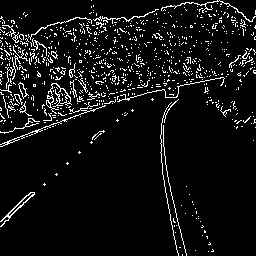

In [277]:
test_generator(train_generator, draw_line=True, input_shape=INPUT_SHAPE,max_lines_per_frame=MAX_LINES_PER_FRAME)

### Build model

In [304]:
def build_model(polyline_width_output_shape:int ,polyline_height_output_shape:int, input_shape:Tuple[int,int,int], model_name:str):

    input_img = layers.Input(shape=input_shape)

    # First block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(input_img)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Second block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Third block
    layer = layers.Conv2D(128, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Fourth block
    layer = layers.Conv2D(64, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)

    # GlobalMaxPool
    layer = layers.GlobalMaxPool2D()(layer)

    # polyline common part 
    polyline_common = tf.keras.layers.Dense(units=512, activation='relu')(layer)
    polyline_common = layers.BatchNormalization()(polyline_common)
    polyline_common = layers.Dropout(.2)(polyline_common) 

    # polyline height
    pol_1 = tf.keras.layers.Dense(units=256, activation='relu')(polyline_common)
    pol_1 = layers.BatchNormalization()(pol_1)
    pol_1 = layers.Dropout(.2)(pol_1)

    pol_1 = tf.keras.layers.Dense(units=128,activation='relu')(pol_1)
    pol_1 = layers.BatchNormalization()(pol_1)
    pol_1 = layers.Dropout(.2)(pol_1)

    # polyline width 
    pol_2 = tf.keras.layers.Dense(units=256, activation='relu')(polyline_common)
    pol_2 = layers.BatchNormalization()(pol_2)
    pol_2 = layers.Dropout(.2)(pol_2)

    pol_2 = tf.keras.layers.Dense(units=128,activation='relu')(pol_2)
    pol_2 = layers.BatchNormalization()(pol_2)
    pol_2 = layers.Dropout(.2)(pol_2)

    # output
    polyline_output_width = layers.Dense(polyline_width_output_shape,name='polyline_width')(pol_1)
    polyline_output_height = layers.Dense(polyline_height_output_shape,name='polyline_height')(pol_2)

    model = Model(input_img, outputs=[
        polyline_output_width,
        polyline_output_height,
      ], name = model_name
    )

    return model

### Callbacks initialization

In [305]:
model_name = MODEL_NAME
logdir = f"logs/{model_name}"
checkpoint_filepath = f"/model/{model_name}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop_polyline_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_polyline_width_loss'
)

reduce_lr_callback_depends_on_polyline_1_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_width_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)
reduce_lr_callback_depends_on_polyline_2_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_height_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_polyline_width_loss',
    mode='max',
    save_best_only=True)

### Load test image

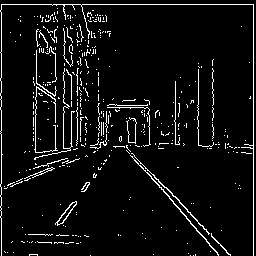

In [306]:
frame_path = '/content/drive/My Drive/Ilmenau/tusimple/test_frame.png'

frame = cv2.imread(frame_path)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img_gaussian = cv2.GaussianBlur(gray,(3,3),0)
img_gaussian = cv2.resize(img_gaussian, (FINAL_SHAPE))
img_canny = cv2.Canny(img_gaussian, FINAL_SHAPE[0], FINAL_SHAPE[1])      
frame = tf.keras.preprocessing.image.img_to_array(img_canny)
frame = frame * 255
cv2_imshow(frame)

### Draw line at the end of an epoch

In [318]:
class DrawPolylineOnEpochEnd(tf.keras.callbacks.Callback):
  """Draw polyline at the end on the epoch to test the net. It skip one batch on validation but похуй"""
  def __init__(self, test_frame:np.ndarray,train_generator, validation_generator,model,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.model = model
    self.test_frame = test_frame

  def __filter_coordination_for_resolution(self, polyline: np.ndarray) -> np.ndarray:
    valid = ((polyline[:, 0] > 0) & (polyline[:, 1] > 0)
              & (polyline[:, 0] < INPUT_SHAPE[0]) & (polyline[:, 1] < INPUT_SHAPE[1]))
    return polyline[valid]

  def __filter_coordinates(self, list_of_polylines: List[np.ndarray]) -> np.ndarray:
    """Remove empty points and coordinates x or y, that is less than 0"""
    list_of_polylines = list(map(lambda x: x.reshape(-1, 2), list_of_polylines))
    return list(map(lambda polyline: self.__filter_coordination_for_resolution(polyline),
                    list_of_polylines))  

  def concat_polyline(self,polyline_width: np.ndarray, polyline_height: np.ndarray) -> np.ndarray: 
    return np.concatenate((polyline_width.reshape(-1, 1), polyline_height.reshape(-1, 1)), axis=1)

  def test_model(self, generator: Sequence):
    original_frames, original_polylines = generator[0]
    original_frame = original_frames[0]
    draw_original_polylines_frame = draw_polyline_in_frame(
        original_frame,
        original_polylines,
        thickness=2,
        max_lines_per_frame=MAX_LINES_PER_FRAME, 
        input_shape=INPUT_SHAPE
    )

    original_frame = np.copy(original_frame)
    frame = np.expand_dims(original_frame, 0)
    res = self.model.predict(frame)

    final_frame = draw_polyline_in_frame(
        draw_original_polylines_frame,
        res,
        thickness=5, 
        max_lines_per_frame=MAX_LINES_PER_FRAME, 
        input_shape=INPUT_SHAPE
    )
    cv2_imshow(final_frame * 255)

  def on_epoch_end(self, epoch, logs=None):
      print(f'Epoch {epoch+1}. Draw polylines on train generator...')
      self.test_model(self.train_generator)
      print('Test on test image...')
      self.test_on_image()

  def test_on_image(self):
    frame = np.expand_dims(self.test_frame, 0)
    res = self.model.predict(frame)
    res_frame = draw_polyline_in_frame(
        self.test_frame,
        res,thickness=5,        
        max_lines_per_frame=MAX_LINES_PER_FRAME, 
        input_shape=INPUT_SHAPE
    )
    cv2_imshow(res_frame * 255)

In [308]:
model = build_model(
    polyline_width_output_shape = MAX_NUM_POINTS * MAX_LINES_PER_FRAME, 
    polyline_height_output_shape = MAX_NUM_POINTS * MAX_LINES_PER_FRAME, 
    input_shape = INPUT_SHAPE,
    model_name = MODEL_NAME,
)
# print(model.summary())

Epoch 2. Draw polylines on train generator...
[[146.19999695  85.33333588]
 [129.19999695  96.        ]
 [119.40000153 106.66666412]
 [110.         117.33333588]
 [102.         128.        ]
 [ 94.40000153 138.66667175]
 [ 86.80000305 149.33332825]
 [ 79.19999695 160.        ]
 [ 71.59999847 170.66667175]
 [ 64.         181.33332825]
 [ 56.40000153 192.        ]
 [ 48.79999924 202.66667175]
 [ 41.20000076 213.33332825]
 [ 33.59999847 224.        ]
 [ 26.20000076 234.66667175]
 [ 18.60000038 245.33332825]]
[[157.80000305  85.33333588]
 [152.19999695  96.        ]
 [151.         106.66666412]
 [153.3999939  117.33333588]
 [155.80000305 128.        ]
 [158.19999695 138.66667175]
 [162.6000061  149.33332825]
 [167.19999695 160.        ]
 [171.6000061  170.66667175]
 [176.19999695 181.33332825]
 [180.6000061  192.        ]
 [185.19999695 202.66667175]
 [189.6000061  213.33332825]
 [194.19999695 224.        ]
 [198.6000061  234.66667175]
 [203.19999695 245.33332825]]
[[ 93.47557   93.82913 ]

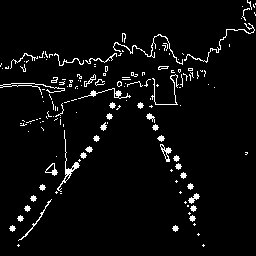

Test on test image...
[]
[]


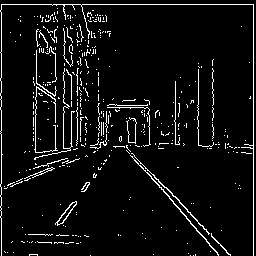

In [320]:
DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model, test_frame=frame).on_epoch_end(1)

In [309]:
# tf.experimental.numpy.experimental_enable_numpy_behavior()
# tf.keras.utils.plot_model(model, "multi_output_model.png", show_shapes=True)

### model compile and fit

In [310]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01

model.compile(loss= {
      'polyline_width':tf.keras.losses.MeanAbsoluteError(),
      'polyline_height':tf.keras.losses.MeanAbsoluteError(),
    },
    optimizer=Adam(learning_rate=learning_rate),
    metrics={'polyline_width':tf.keras.metrics.MeanSquaredError(),
             'polyline_height':tf.keras.metrics.MeanSquaredError(),
             },)

Epoch 1/3
Epoch 1. Draw polylines on train generator...


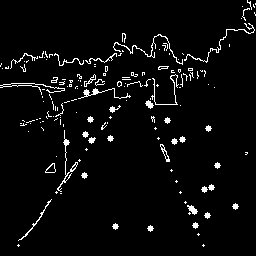

Test on test image...


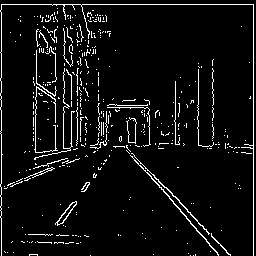

821/821 - 346s - loss: 0.3869 - polyline_width_loss: 0.1904 - polyline_height_loss: 0.1965 - polyline_width_mean_squared_error: 0.1735 - polyline_height_mean_squared_error: 0.1833 - val_loss: 0.6558 - val_polyline_width_loss: 0.4165 - val_polyline_height_loss: 0.2392 - val_polyline_width_mean_squared_error: 0.5528 - val_polyline_height_mean_squared_error: 0.3332 - lr: 0.0100 - 346s/epoch - 422ms/step
Epoch 2/3
Epoch 2. Draw polylines on train generator...


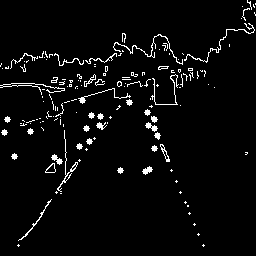

Test on test image...


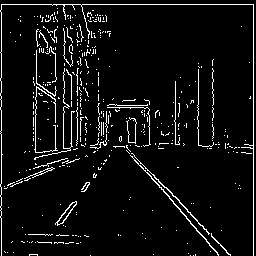

821/821 - 341s - loss: 0.2526 - polyline_width_loss: 0.1263 - polyline_height_loss: 0.1264 - polyline_width_mean_squared_error: 0.1120 - polyline_height_mean_squared_error: 0.1142 - val_loss: 0.8340 - val_polyline_width_loss: 0.4086 - val_polyline_height_loss: 0.4254 - val_polyline_width_mean_squared_error: 0.4974 - val_polyline_height_mean_squared_error: 0.6069 - lr: 0.0100 - 341s/epoch - 415ms/step
Epoch 3/3

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.
Epoch 3. Draw polylines on train generator...


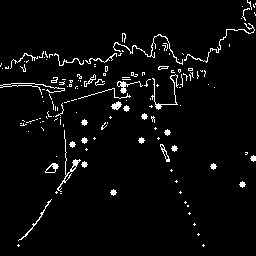

Test on test image...


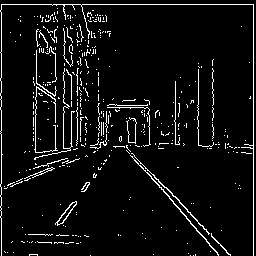

821/821 - 333s - loss: 0.2458 - polyline_width_loss: 0.1232 - polyline_height_loss: 0.1226 - polyline_width_mean_squared_error: 0.1086 - polyline_height_mean_squared_error: 0.1095 - val_loss: 0.6738 - val_polyline_width_loss: 0.4227 - val_polyline_height_loss: 0.2512 - val_polyline_width_mean_squared_error: 0.5484 - val_polyline_height_mean_squared_error: 0.3325 - lr: 0.0100 - 333s/epoch - 405ms/step


In [311]:
history = model.fit(train_generator,
                    epochs=3,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(
                            train_generator=train_generator, 
                            validation_generator=validation_generator,
                            model=model, 
                            test_frame=frame,
                          ),
                      ],
                    )

In [312]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

Epoch 1/10
Epoch 1. Draw polylines on train generator...


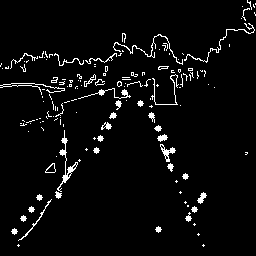

Test on test image...


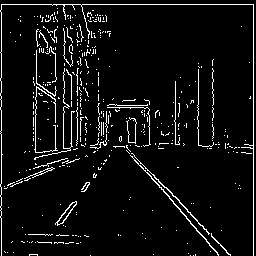

821/821 - 343s - loss: 0.2215 - polyline_width_loss: 0.1122 - polyline_height_loss: 0.1093 - polyline_width_mean_squared_error: 0.1023 - polyline_height_mean_squared_error: 0.1009 - val_loss: 0.5715 - val_polyline_width_loss: 0.3200 - val_polyline_height_loss: 0.2515 - val_polyline_width_mean_squared_error: 0.3790 - val_polyline_height_mean_squared_error: 0.3724 - lr: 0.0010 - 343s/epoch - 418ms/step
Epoch 2/10
Epoch 2. Draw polylines on train generator...


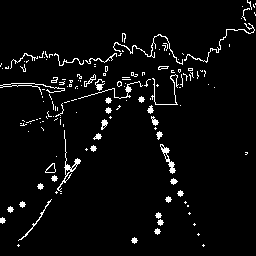

Test on test image...


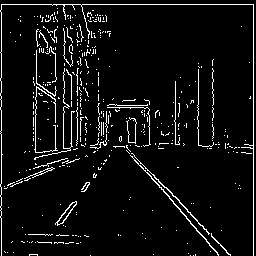

821/821 - 342s - loss: 0.2171 - polyline_width_loss: 0.1100 - polyline_height_loss: 0.1071 - polyline_width_mean_squared_error: 0.0999 - polyline_height_mean_squared_error: 0.0985 - val_loss: 0.5434 - val_polyline_width_loss: 0.3142 - val_polyline_height_loss: 0.2292 - val_polyline_width_mean_squared_error: 0.3643 - val_polyline_height_mean_squared_error: 0.3473 - lr: 0.0010 - 342s/epoch - 416ms/step
Epoch 3/10
Epoch 3. Draw polylines on train generator...


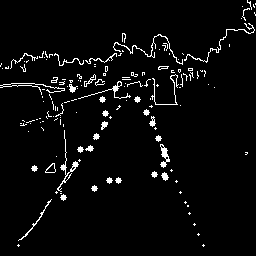

Test on test image...


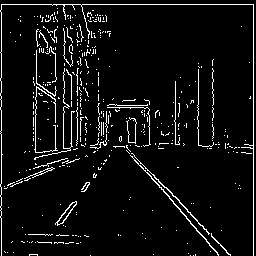

821/821 - 324s - loss: 0.2146 - polyline_width_loss: 0.1083 - polyline_height_loss: 0.1063 - polyline_width_mean_squared_error: 0.0985 - polyline_height_mean_squared_error: 0.0974 - val_loss: 0.5961 - val_polyline_width_loss: 0.3231 - val_polyline_height_loss: 0.2730 - val_polyline_width_mean_squared_error: 0.3758 - val_polyline_height_mean_squared_error: 0.3968 - lr: 0.0010 - 324s/epoch - 394ms/step
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 4. Draw polylines on train generator...


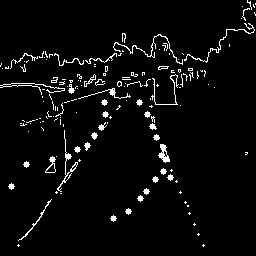

Test on test image...


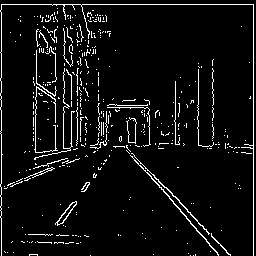

821/821 - 324s - loss: 0.2132 - polyline_width_loss: 0.1077 - polyline_height_loss: 0.1055 - polyline_width_mean_squared_error: 0.0976 - polyline_height_mean_squared_error: 0.0962 - val_loss: 0.5836 - val_polyline_width_loss: 0.3203 - val_polyline_height_loss: 0.2633 - val_polyline_width_mean_squared_error: 0.3716 - val_polyline_height_mean_squared_error: 0.3887 - lr: 8.0000e-04 - 324s/epoch - 395ms/step
Epoch 5/10
Epoch 5. Draw polylines on train generator...


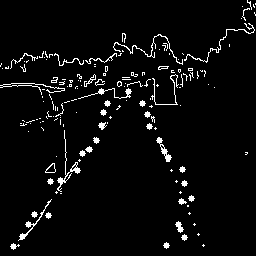

Test on test image...


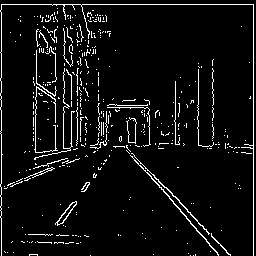

821/821 - 326s - loss: 0.2096 - polyline_width_loss: 0.1058 - polyline_height_loss: 0.1038 - polyline_width_mean_squared_error: 0.0964 - polyline_height_mean_squared_error: 0.0950 - val_loss: 0.5185 - val_polyline_width_loss: 0.3027 - val_polyline_height_loss: 0.2158 - val_polyline_width_mean_squared_error: 0.3605 - val_polyline_height_mean_squared_error: 0.3329 - lr: 6.4000e-04 - 326s/epoch - 397ms/step
Epoch 6/10
Epoch 6. Draw polylines on train generator...


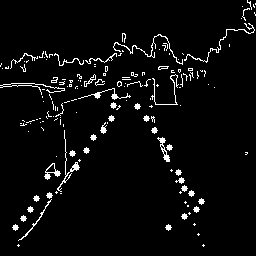

Test on test image...


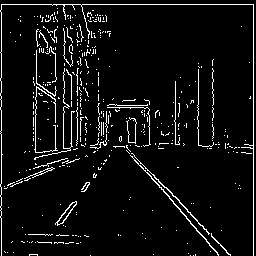

821/821 - 325s - loss: 0.2087 - polyline_width_loss: 0.1053 - polyline_height_loss: 0.1034 - polyline_width_mean_squared_error: 0.0959 - polyline_height_mean_squared_error: 0.0941 - val_loss: 0.5134 - val_polyline_width_loss: 0.2996 - val_polyline_height_loss: 0.2138 - val_polyline_width_mean_squared_error: 0.3551 - val_polyline_height_mean_squared_error: 0.3318 - lr: 6.4000e-04 - 325s/epoch - 395ms/step
Epoch 7/10
Epoch 7. Draw polylines on train generator...


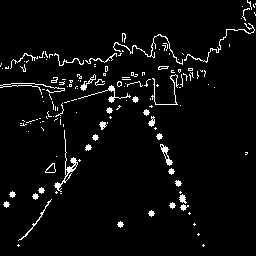

Test on test image...


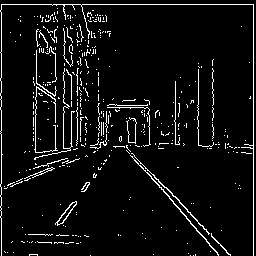

821/821 - 325s - loss: 0.2068 - polyline_width_loss: 0.1044 - polyline_height_loss: 0.1024 - polyline_width_mean_squared_error: 0.0950 - polyline_height_mean_squared_error: 0.0933 - val_loss: 0.5764 - val_polyline_width_loss: 0.3207 - val_polyline_height_loss: 0.2556 - val_polyline_width_mean_squared_error: 0.3844 - val_polyline_height_mean_squared_error: 0.3834 - lr: 6.4000e-04 - 325s/epoch - 396ms/step
Epoch 8/10

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 8. Draw polylines on train generator...


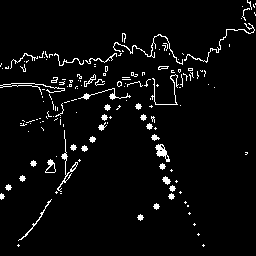

Test on test image...


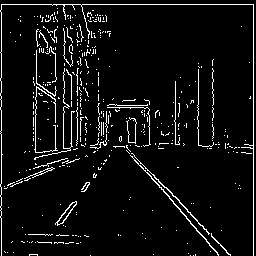

821/821 - 327s - loss: 0.2060 - polyline_width_loss: 0.1037 - polyline_height_loss: 0.1023 - polyline_width_mean_squared_error: 0.0943 - polyline_height_mean_squared_error: 0.0930 - val_loss: 0.5576 - val_polyline_width_loss: 0.3119 - val_polyline_height_loss: 0.2457 - val_polyline_width_mean_squared_error: 0.3679 - val_polyline_height_mean_squared_error: 0.3687 - lr: 5.1200e-04 - 327s/epoch - 399ms/step
Epoch 9/10
Epoch 9. Draw polylines on train generator...


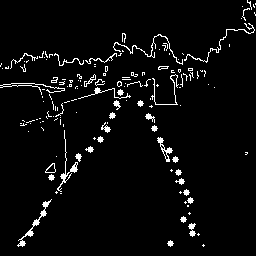

Test on test image...


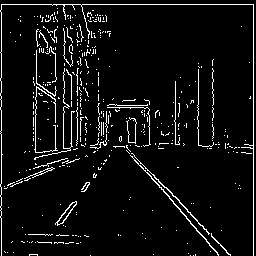

821/821 - 327s - loss: 0.2033 - polyline_width_loss: 0.1023 - polyline_height_loss: 0.1010 - polyline_width_mean_squared_error: 0.0929 - polyline_height_mean_squared_error: 0.0923 - val_loss: 0.5165 - val_polyline_width_loss: 0.2982 - val_polyline_height_loss: 0.2184 - val_polyline_width_mean_squared_error: 0.3558 - val_polyline_height_mean_squared_error: 0.3386 - lr: 4.0960e-04 - 327s/epoch - 398ms/step
Epoch 10/10

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 10. Draw polylines on train generator...


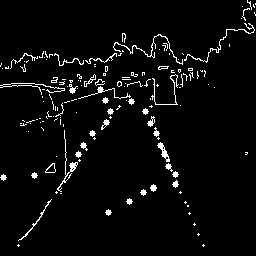

Test on test image...


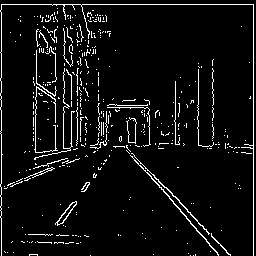

821/821 - 330s - loss: 0.2026 - polyline_width_loss: 0.1019 - polyline_height_loss: 0.1007 - polyline_width_mean_squared_error: 0.0923 - polyline_height_mean_squared_error: 0.0915 - val_loss: 0.5671 - val_polyline_width_loss: 0.3182 - val_polyline_height_loss: 0.2489 - val_polyline_width_mean_squared_error: 0.3777 - val_polyline_height_mean_squared_error: 0.3766 - lr: 4.0960e-04 - 330s/epoch - 401ms/step


In [313]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model,test_frame=frame)
                      ],
                    )

In [314]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

Epoch 1/10
Epoch 1. Draw polylines on train generator...


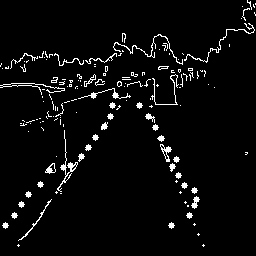

Test on test image...


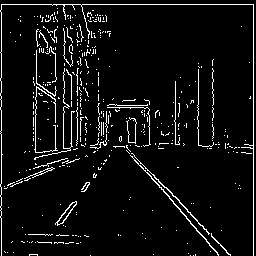

821/821 - 328s - loss: 0.2001 - polyline_width_loss: 0.1006 - polyline_height_loss: 0.0995 - polyline_width_mean_squared_error: 0.0910 - polyline_height_mean_squared_error: 0.0910 - val_loss: 0.5070 - val_polyline_width_loss: 0.2936 - val_polyline_height_loss: 0.2134 - val_polyline_width_mean_squared_error: 0.3466 - val_polyline_height_mean_squared_error: 0.3355 - lr: 1.0000e-04 - 328s/epoch - 400ms/step
Epoch 2/10
Epoch 2. Draw polylines on train generator...


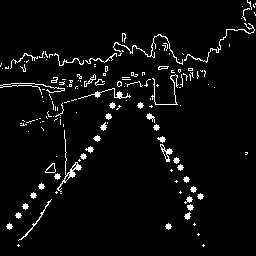

Test on test image...


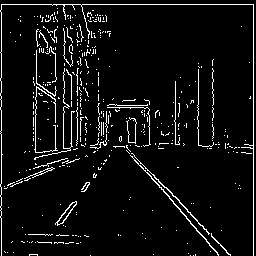

821/821 - 328s - loss: 0.1995 - polyline_width_loss: 0.1003 - polyline_height_loss: 0.0992 - polyline_width_mean_squared_error: 0.0908 - polyline_height_mean_squared_error: 0.0907 - val_loss: 0.5078 - val_polyline_width_loss: 0.2935 - val_polyline_height_loss: 0.2144 - val_polyline_width_mean_squared_error: 0.3472 - val_polyline_height_mean_squared_error: 0.3355 - lr: 1.0000e-04 - 328s/epoch - 400ms/step
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
Epoch 3. Draw polylines on train generator...


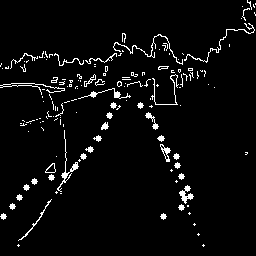

Test on test image...


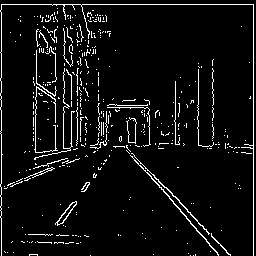

821/821 - 329s - loss: 0.1990 - polyline_width_loss: 0.0998 - polyline_height_loss: 0.0992 - polyline_width_mean_squared_error: 0.0903 - polyline_height_mean_squared_error: 0.0906 - val_loss: 0.5168 - val_polyline_width_loss: 0.2966 - val_polyline_height_loss: 0.2202 - val_polyline_width_mean_squared_error: 0.3481 - val_polyline_height_mean_squared_error: 0.3396 - lr: 1.0000e-04 - 329s/epoch - 401ms/step
Epoch 4/10
Epoch 4. Draw polylines on train generator...


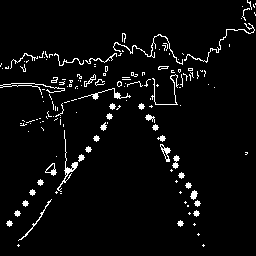

Test on test image...


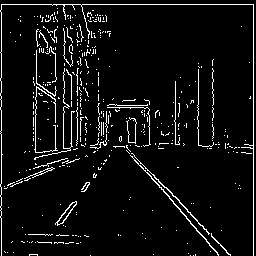

821/821 - 327s - loss: 0.1983 - polyline_width_loss: 0.0995 - polyline_height_loss: 0.0989 - polyline_width_mean_squared_error: 0.0900 - polyline_height_mean_squared_error: 0.0902 - val_loss: 0.5046 - val_polyline_width_loss: 0.2904 - val_polyline_height_loss: 0.2143 - val_polyline_width_mean_squared_error: 0.3427 - val_polyline_height_mean_squared_error: 0.3348 - lr: 8.0000e-05 - 327s/epoch - 398ms/step
Epoch 5/10


KeyboardInterrupt: ignored

In [315]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_1_loss,
                        reduce_lr_callback_depends_on_polyline_2_loss,
                        model_checkpoint_callback,
                        DrawPolylineOnEpochEnd(train_generator=train_generator, validation_generator=validation_generator,model=model,test_frame=frame)
                      ],
                    )

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
from google.colab import files

In [ ]:
model_name_download = MODEL_NAME + '.h5'
model_name_download

In [ ]:
model.save(model_name_download)

In [ ]:
files.download(model_name_download)

In [ ]:
model